In [1]:
import sys
# sys.path.append('src')
import os
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns
import sklearn
import phate
import hdbscan
import matplotlib.pyplot as plt
os.chdir('../../src/')
from train_AE import DenoisingAutoencoder
from preprocess import maf_scale
import data_loader
import mappings
import scprep
import torch

In [ ]:
# define paths
PROJECT_PATH = '/home/mila/s/shuang.ni/phate_genetics/shuang/'
SCRATCH_PATH = '/home/mila/s/shuang.ni/scratch/phate_genetics/'

DATA_PATH = SCRATCH_PATH + '1KGP/V3/'
SAVE_PATH = SCRATCH_PATH + 'results/'
Figure_PATH = PROJECT_PATH + 'figures/'

In [ ]:
# import data
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed.hdf5'
data, class_labels, samples, snp_names, class_label_names = data_loader.load_data_1000G(os.path.join(DATA_PATH, fname))
label_pop, label_superpop = data_loader.preprocess_labels_1000G(class_labels, class_label_names)

# normalize data
maf_scaled_data = maf_scale(data)
data_tensor = torch.from_numpy(maf_scaled_data).float()
input_dim = data.shape[1]

# 100D AE + PHATE

In [6]:
# trained model path
model_save_path = SAVE_PATH + 'AE/ae_trained_model_750.pth'

In [7]:
# Initialize the model
latent_dim = 100  # Latent space dimension
model = DenoisingAutoencoder(input_dim=input_dim, latent_dim=latent_dim)

# Load the trained model's weights
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode

# Assuming `data` is your input tensor, move it to the correct device if necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data = data_tensor.to(device)  # Move data to device

# Use the encoder for inference (dimensionality reduction)
with torch.no_grad():  # Disable gradient computation for inference
    reduced_data = model.encoder(data)

In [6]:
reduced_data_np = reduced_data.cpu().numpy()

In [ ]:
df = pd.DataFrame(reduced_data_np)
df.index = samples
df.to_csv('/home/mila/s/shuang.ni/phate_genetics/data/1000G/1000G_AE.csv')

In [7]:
# initial phate embedding
phate_operator_2d = phate.PHATE(random_state=42, 
                                n_components=2, 
                                knn=6, 
                                t=6, 
                                decay=60,
                                n_pca=None)
phate_operator_2d.fit(reduced_data_np)
phate_emb_2d = phate_operator_2d.transform()

Running PHATE on 2504 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.87 seconds.
  Calculating affinities...
  Calculated affinities in 0.08 seconds.
Calculated graph and diffusion operator in 0.95 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.21 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.80 seconds.
Calculated landmark operator in 3.12 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.30 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.12 seconds.


<Axes: title={'center': '1000G superpopulation'}, xlabel='PHATE 1', ylabel='PHATE 2'>

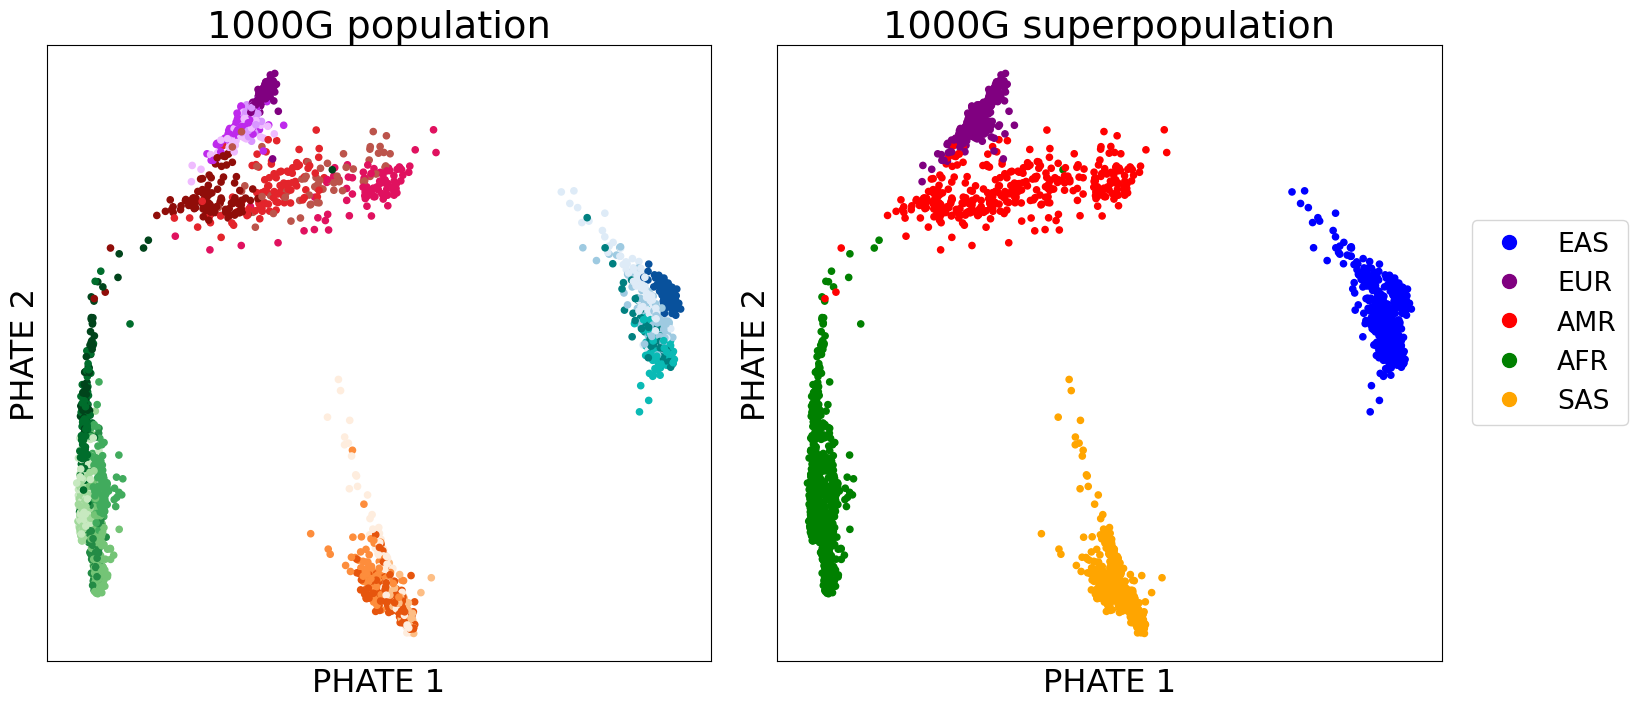

In [9]:
fig, axes = plt.subplots(1,2, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.1})

scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[0],
                      cmap=mappings.pop_pallette_1000G_fine, c=label_pop,
                      xticks=False, yticks=False, legend=False,
                      label_prefix="PHATE ",title='1000G population', fontsize=16)
scprep.plot.scatter2d(phate_emb_2d, s=20, ax=axes[1],
                      cmap=mappings.pop_pallette_1000G_coarse, c=label_superpop,
                      xticks=False, yticks=False, legend=True,
                      legend_loc='right', legend_anchor=(1.3, 0.55), legend_ncol=1,
                      label_prefix="PHATE ",title='1000G superpopulation', fontsize=16)

In [50]:
def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

admix_ratios = load_from_local('../data/1000G/1000G_admix_ratios')

In [51]:
# plot admixture function
def plot_admixture(embedding, admix_ratios, ax, label_prefix = None):
    for col, score_name in enumerate(admix_ratios.columns):
        has_admixed_estimate = admix_ratios[score_name] > 0

        scatter_no_admix = scprep.plot.scatter2d(embedding[~has_admixed_estimate], 
                                                 s=10, 
                                                 ax=ax[col],
                                                 color=[0.5, 0.5, 0.5, 1], 
                                                 xticks=False, 
                                                 yticks=False, 
                                                 legend=False,
                                                 label_prefix=label_prefix, 
                                                 fontsize=18)
        scatter_admix = scprep.plot.scatter2d(embedding[has_admixed_estimate], 
                                              s=10, ax=ax[col],
                                              c=admix_ratios[score_name][has_admixed_estimate], 
                                              xticks=False, 
                                              yticks=False, 
                                              legend=False,
                                              label_prefix=label_prefix, 
                                              fontsize=18, 
                                              cmap='seismic')

    # Add custom legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='No admixture estimate'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Low admixture %'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High admixture %')
    ]

    return scatter_no_admix, scatter_admix, legend_elements


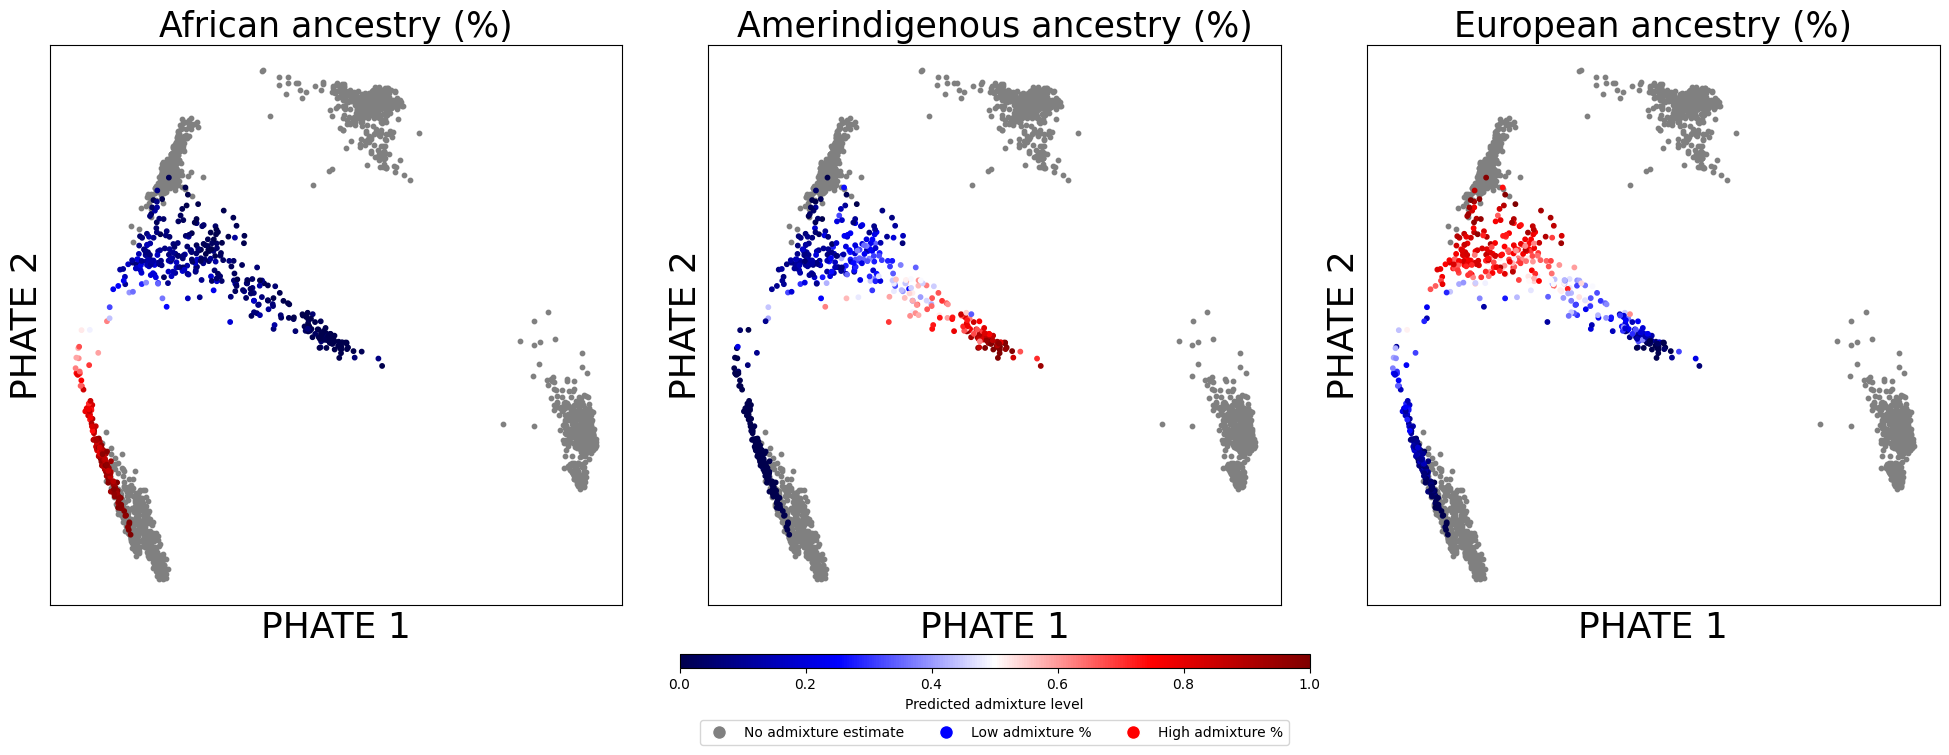

In [52]:
fig, ax = plt.subplots(ncols=3, figsize=(21, 7), gridspec_kw={'wspace': 0.15})

scatter_no_admix, scatter_admix, legend_elements = plot_admixture(phate_emb_2d, admix_ratios, ax, label_prefix='PHATE ')

for i, score_name in enumerate(admix_ratios.columns):
    ax[i].set_title(score_name, fontsize=25)

# Add colorbar
cbar_ax = fig.add_axes([0.35, 0.06, 0.3, 0.02])  # Adjust these values as needed for position and size
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.seismic), cax=cbar_ax, orientation='horizontal', fraction=0.02)
cbar.set_label('Predicted admixture level')

# Add custom legend
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.06), ncol=3)

# Manually adjust the layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, hspace=0.3, wspace=0.3)

plt.show()

# 2D AE embedding

In [8]:
# trained model path
model_save_path = SAVE_PATH + 'AE/ae_trained_model_2D_1000G.pth'

In [5]:
# Initialize the model
latent_dim = 2  # Latent space dimension
model = DenoisingAutoencoder(input_dim=input_dim, latent_dim=latent_dim)

# Load the trained model's weights
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode

# Assuming `data` is your input tensor, move it to the correct device if necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data = data_tensor.to(device)  # Move data to device

# Use the encoder for inference (dimensionality reduction)
with torch.no_grad():  # Disable gradient computation for inference
    reduced_data = model.encoder(data)

RuntimeError: Error(s) in loading state_dict for DenoisingAutoencoder:
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([512, 228396]) from checkpoint, the shape in current model is torch.Size([512, 229986]).
	size mismatch for decoder.4.weight: copying a param with shape torch.Size([228396, 512]) from checkpoint, the shape in current model is torch.Size([229986, 512]).
	size mismatch for decoder.4.bias: copying a param with shape torch.Size([228396]) from checkpoint, the shape in current model is torch.Size([229986]).

In [ ]:
reduced_data_np = reduced_data.cpu().numpy()

In [ ]:
df = pd.DataFrame(reduced_data_np)
df.index = samples
df.to_csv('/home/mila/s/shuang.ni/phate_genetics/data/1000G/1000G_AE_2D_emb.csv')